<a href="https://colab.research.google.com/github/Se1towo/IMLO_Exam/blob/main/IMLO_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [140]:
# Download full dataset
flowers_102 = torchvision.datasets.Flowers102(
    root="data",
    download=True,
    transform=ToTensor())

In [141]:
# Get dimensions of largest image
max_width = 0
max_height = 0

for i in range(len(flowers_102)):
    img, label = flowers_102[i]
    _, width, height = img.size()  # Get the dimensions of the image
    max_width = max(max_width, width)
    max_height = max(max_height, height)

In [149]:
# Pads all images to be uniform (dimensions of largest image)
transform = transforms.Compose([
    transforms.Pad(padding=((max_width - width)//2, (max_height - height)//2)),
    transforms.Resize((max_width, max_height)),
    transforms.ToTensor()
])
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

# Split the dataset into test and train datasets
training_data = torchvision.datasets.Flowers102(
    root="data",
    split = "train",
    download=True,
    transform=transform)

test_data = torchvision.datasets.Flowers102(
    root="data",
    split = "test",
    download=True,
    transform=transform)

In [ ]:
# # Split the dataset into test and train datasets
# training_data = torchvision.datasets.Flowers102(
#     root="data",
#     split = "train",
#     download=True,
#     transform=ToTensor())

# test_data = torchvision.datasets.Flowers102(
#     root="data",
#     split = "test",
#     download=True,
#     transform=ToTensor())

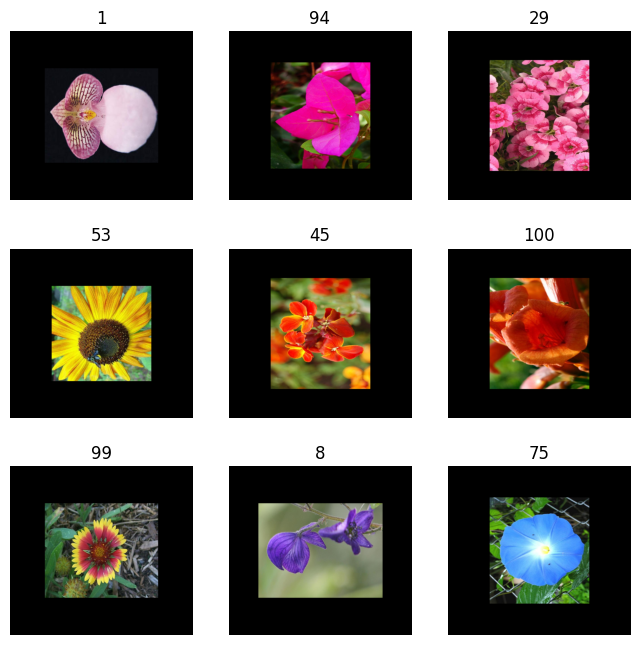

In [145]:
labels_map = {}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    if label not in labels_map:
      labels_map[label] = img
    figure.add_subplot(rows, cols, i)
    plt.title(list(labels_map.keys())[i-1])
    plt.axis("off")
    plt.imshow(img.squeeze().T)
plt.show()

In [146]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [147]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 993, 919])
Labels batch shape: torch.Size([64])


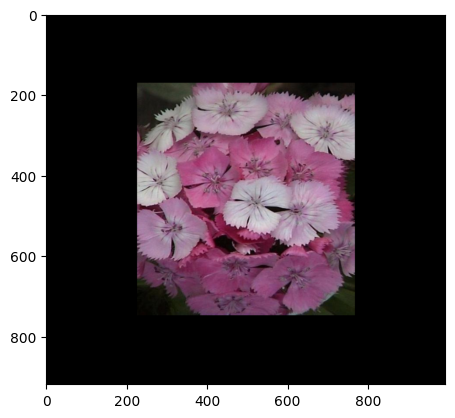

Label: 29


In [148]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T)
plt.show()
print(f"Label: {label}")

In [155]:
# Try to train model on hardware accelerator
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [156]:
# Define model for neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [175]:
X = torch.rand(1, 28, 28, device=device) #change from 28 by 28?
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([5])


In [179]:
# Take minibatch to test layers
input_image = torch.rand(3,28,28)
print(input_image.size())

# Convert each iamge to a continguous array of pixel values
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

# Apply lienar transformation
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

#Introduce nonlinearity
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

#Pass data sequentially
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

#Rescale outputs to sum to 1
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

torch.Size([3, 28, 28])
torch.Size([3, 784])
torch.Size([3, 20])
Before ReLU: tensor([[ 0.0305, -0.3717,  0.4083, -0.3972,  0.2922,  0.1529, -0.1662, -0.1305,
          0.0047, -0.2426, -0.5270, -0.0381,  0.3168,  0.6645, -0.0034, -0.4511,
          0.3113,  0.1951, -0.2784, -0.0569],
        [ 0.2124, -0.0915,  0.3029,  0.0349,  0.2822,  0.2040, -0.4896, -0.3477,
         -0.1019, -0.0402, -0.3318,  0.1819,  0.7060,  0.3236,  0.1010, -0.3633,
          0.3692, -0.0319, -0.2040,  0.2320],
        [ 0.1580, -0.1520,  0.5287, -0.1798,  0.0442,  0.0370, -0.7570, -0.2669,
         -0.2274, -0.3139, -0.4238,  0.1985,  0.5263,  0.4040, -0.1165, -0.2882,
          0.3300,  0.1433, -0.3512,  0.1506]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0305, 0.0000, 0.4083, 0.0000, 0.2922, 0.1529, 0.0000, 0.0000, 0.0047,
         0.0000, 0.0000, 0.0000, 0.3168, 0.6645, 0.0000, 0.0000, 0.3113, 0.1951,
         0.0000, 0.0000],
        [0.2124, 0.0000, 0.3029, 0.0349, 0.2822, 0.2040, 0.0000, 0.00

In [180]:
# Iterate over each parameter, and print its size and a preview of its value
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0306, -0.0172, -0.0033,  ...,  0.0336, -0.0242, -0.0319],
        [ 0.0040, -0.0205, -0.0170,  ...,  0.0266,  0.0259,  0.0045]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([0.0104, 0.0237], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0127,  0.0149,  0.0429,  ...,  0.0007,  0.0024, -0.0209],
        [-0.0066, -0.0319, -0.0272,  ..., -0.0264, -0.0051,  0.0316]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Si

In [181]:
# Establishing Loss function and Optimiser
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [186]:
# Cmpute gradient of loss function with respect to given parameter for simplest one-layer neural network
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [187]:
# Backward propogation
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7b8f1044d930>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7b8f1044e140>


In [188]:
# Optimize weights of parameters in the neural network,by computing the derivatives of our loss function with respect to parameters
# Compute gradients
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0019, 0.3273, 0.3211],
        [0.0019, 0.3273, 0.3211],
        [0.0019, 0.3273, 0.3211],
        [0.0019, 0.3273, 0.3211],
        [0.0019, 0.3273, 0.3211]])
tensor([0.0019, 0.3273, 0.3211])


In [158]:
# Training the model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [159]:
# Check the accuracy of the model against the actual labels in the dataset
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [160]:
# Repeat the accuracy test over mulitple epochs to increase the accuracy of predictions
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x2737701 and 784x512)

In [12]:
batch_size = 64

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

RuntimeError: stack expects each tensor to be equal size, but got [3, 500, 523] at entry 0 and [3, 500, 666] at entry 1

In [ ]:
# Visualise a sample of the data
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
# Save the model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")